In [1]:
import stim

c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,
)
c = c.flattened()

In [2]:
import pyzx as zx

from faulttools.glue.pyzx import to_pyzx
from faulttools.glue.stim import from_stim

d, nm = from_stim(c)
print(len(nm.atomic_weights()))

zx_diagram, node_map = to_pyzx(d, with_mapping=True)
reverse_node_map = { pyzx_node: n for n, pyzx_node in node_map.items() }
zx.draw(zx_diagram, labels=True)

445


In [3]:
import sinter
from faulttools.glue.stim import export_to_stim_dem, wrap_dem_as_sinter_task
from faulttools import PauliString

stim_dem = c.detector_error_model()
dem = export_to_stim_dem(nm, logicals=[PauliString({
    d.edge_indices_from_endpoints(reverse_node_map[63], reverse_node_map[81])[0]: "X",
    d.edge_indices_from_endpoints(reverse_node_map[60], reverse_node_map[82])[0]: "X",
    d.edge_indices_from_endpoints(reverse_node_map[67], reverse_node_map[83])[0]: "X",
})])

In [6]:
collected_stats = sinter.collect(
    num_workers=16,
    tasks=[
        sinter.Task(circuit=c,detector_error_model=stim_dem, json_metadata={"p": 0.001, "name": "stim original"}),
        wrap_dem_as_sinter_task(dem, json_metadata={"p": 0.001, "name": "replica"}),
    ],
    max_shots=100_000_000,
    decoders=["vacuous"],
    print_progress=True,
)

Starting 16 workers...
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m   99862511        1583 p=0.001,name=stim original
        8 vacuous   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m   94639224       62029 p=0.001,name=stim original
        8 vacuous   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m   89305208      124008 p=0.001,name=stim original
        8 vacuous   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m   84162680      183408 p=0.001,name=stim original
        8 vacuous   ?  100000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_see

Stim: 0.01160491 error rate
NEW: 0.01158226 error rate


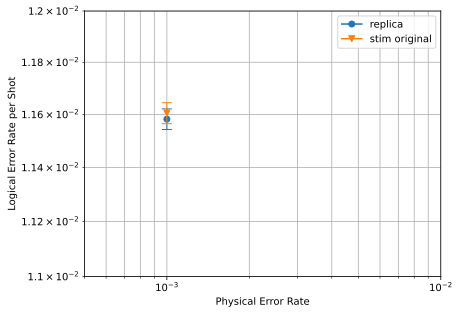

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["name"],
)
print(f"Stim: {collected_stats[0].errors / collected_stats[0].shots} error rate")
print(f"NEW: {collected_stats[1].errors / collected_stats[1].shots} error rate")
ax.set_ylim(0.011, 0.012)
ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger